## import modules

In [338]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel, f_oneway, kruskal
from scipy.stats import norm, binom, chi2_contingency, shapiro, kstest, levene

%reload_ext lab_black

## About Yulu

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.

## Objective:
The company wants to know:

- Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
- How well those variables describe the electric cycle demands

## Column Profiling:

- datetime: datetime
- season: season (1: spring, 2: summer, 3: fall, 4: winter)
- holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
- weather:
    - 1: Clear, Few clouds, partly cloudy, partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: temperature in Celsius
- atemp: feeling temperature in Celsius
- humidity: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- count: count of total rental bikes including both casual and registered

In [195]:
path = "../datasets/yulu_dataset.csv"
df = pd.read_csv(path)
## datetime is object, converting to datatime format.
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [197]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [198]:
df.shape

(10886, 12)

In [199]:
## % of null vales in dataset..
(df.isna().sum() / df.shape[0]) * 100

datetime      0.0
season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

### Obeservations
- 10886 records are their, each records inform about how many bikes were rented during that hour of the day.
- All features are numerical in nature.
- Intially, 'datetime' feature was Object type, changed to pd.datetime format.
- No null values in dataset.

## Convert Numerical to Categorical features

In [200]:
# 1: spring, 2: summer, 3: fall, 4: winter
def season_cat(x):
    if x == 4:
        return "winter"
    elif x == 3:
        return "fall"
    elif x == 2:
        return "summer"
    elif x == 1:
        return "spring"

In [201]:
df["season"] = df["season"].apply(season_cat)

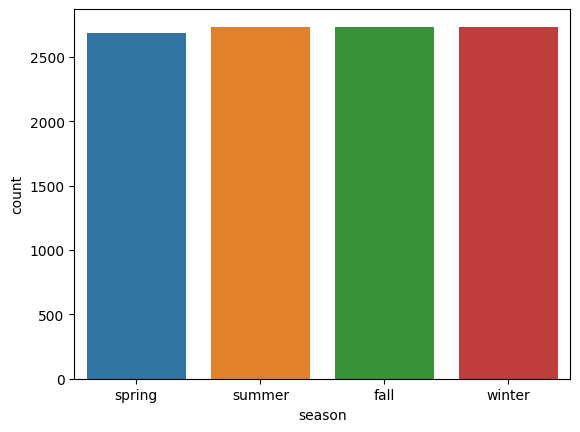

season
winter    2734
summer    2733
fall      2733
spring    2686
Name: count, dtype: int64

In [202]:
sns.countplot(data=df, x="season")
plt.show()
df["season"].value_counts()

<!-- weather:
1: Clear, Few clouds, partly cloudy, partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
<!-- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog --> -->

In [203]:
def cat_weather(x):
    if x == 4:
        return "heavy rain"
    elif x == 3:
        return "little Rain"
    elif x == 2:
        return "cloudy"
    elif x == 1:
        return "clear"


df["weather"] = df["weather"].apply(cat_weather)

In [204]:
df["weather"].value_counts()

weather
clear          7192
cloudy         2834
little Rain     859
heavy rain        1
Name: count, dtype: int64

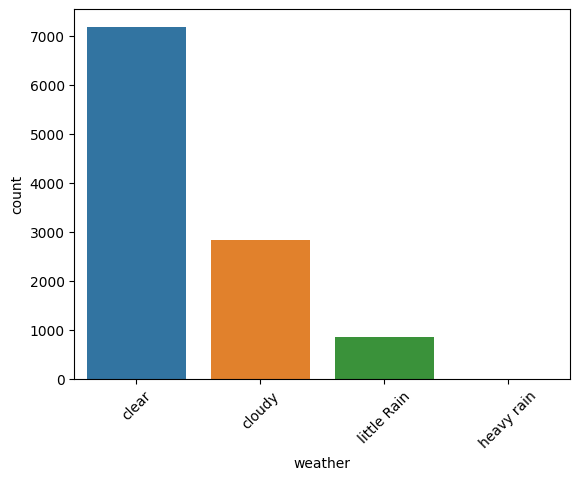

In [205]:
sns.countplot(data=df, x="weather")
plt.xticks(rotation=45)
plt.show()

In [206]:
df["workingday"].replace({1: "yes", 0: "no"}, inplace=True)
df["holiday"].replace({1: "yes", 0: "no"}, inplace=True)
df["day"] = df["datetime"].dt.day_name()
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
df["month_name"] = df["datetime"].dt.month_name()
df["year"] = df["datetime"].dt.year

### Categorising Temperature And Humidity Levels and Windspeed column data :

In [207]:
pd.DataFrame(df["atemp"].describe()).T

,count,mean,std,min,25%,50%,75%,max
atemp,10886.0,23.655084,8.474601,0.76,16.665,24.24,31.06,45.455


In [208]:
def temp_cat(temp):
    if temp <= 12:
        return "very low"
    elif temp > 12 and temp < 24:
        return "low"
    elif temp >= 24 and temp < 35:
        return "moderate"
    elif temp >= 35:
        return "high"

In [209]:
df["temprature"] = df["atemp"].apply(temp_cat)

In [210]:
pd.DataFrame(df["humidity"].describe()).T

,count,mean,std,min,25%,50%,75%,max
humidity,10886.0,61.88646,19.245033,0.0,47.0,62.0,77.0,100.0


In [211]:
def get_humidity(H):
    if 0 <= H <= 10:
        return "10%"
    elif 11 <= H <= 20:
        return "20%"
    elif 21 <= H <= 30:
        return "30%"
    elif 31 <= H <= 40:
        return "40%"
    elif 41 <= H <= 50:
        return "50%"
    elif 51 <= H <= 60:
        return "60%"
    elif 61 <= H <= 70:
        return "70%"
    elif 71 <= H <= 80:
        return "80%"
    elif 81 <= H <= 90:
        return "90%"
    elif 91 <= H <= 100:
        return "100%"

In [212]:
df["gethumidity"] = df["humidity"].apply(get_humidity)

In [213]:
pd.DataFrame(df["windspeed"].describe()).T

,count,mean,std,min,25%,50%,75%,max
windspeed,10886.0,12.799395,8.164537,0.0,7.0015,12.998,16.9979,56.9969


In [214]:
df["windspeed_category"] = pd.qcut(df["windspeed"], 8)
df["windspeed_category"] = df["windspeed_category"].astype("object")

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            10886 non-null  datetime64[ns]
 1   season              10886 non-null  object        
 2   holiday             10886 non-null  object        
 3   workingday          10886 non-null  object        
 4   weather             10886 non-null  object        
 5   temp                10886 non-null  float64       
 6   atemp               10886 non-null  float64       
 7   humidity            10886 non-null  int64         
 8   windspeed           10886 non-null  float64       
 9   casual              10886 non-null  int64         
 10  registered          10886 non-null  int64         
 11  count               10886 non-null  int64         
 12  day                 10886 non-null  object        
 13  month               10886 non-null  int32     

In [216]:
df.describe(include=["object", "category"])

,season,holiday,workingday,weather,day,month_name,temprature,gethumidity,windspeed_category
count,10886,10886,10886,10886,10886,10886,10886,10886,10886
unique,4,2,2,4,7,12,4,10,8
top,winter,no,yes,clear,Saturday,May,moderate,70%,"(-0.001, 6.003]"
freq,2734,10575,7412,7192,1584,912,4767,1845,2185


In [217]:
## Mostly moderate temprature is their.
## Humidity is 70% most of the time.
##

## Coorelation Matrix

In [218]:
df[["temp", "atemp", "humidity", "windspeed", "casual", "registered", "count"]].corr()

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


<Axes: >

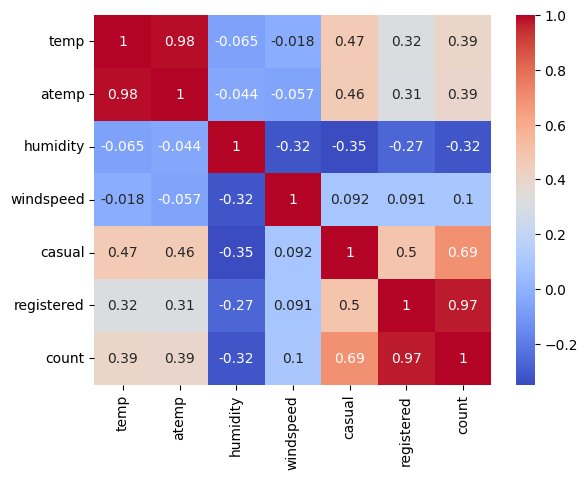

In [219]:
sns.heatmap(
    df[
        ["temp", "atemp", "humidity", "windspeed", "casual", "registered", "count"]
    ].corr(),
    annot=True,
    cmap="coolwarm",
)

## Observations :
- Correlation b/w temprature and Total number bikes rented for all cutomers is 0.39.
- Correlation b/w temprature and number of casual cutomers is 0.47.
- Correlation b/w temprature and number of registered cutomers is 0.32.
- Correlation b/w humidity and Total number bikes rented for all cutomers is -0.32.

## About the features :
- dependent variables : count / registerd / casual
- independent variables : workingday / holiday / weather / seasons /temperature /humidity /windspeed.

## Detect Outlier

In [220]:
def detect_outliers(data):
    length_before = len(data)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    upperbound = Q3 + 1.5 * IQR
    lowerbound = Q1 - 1.5 * IQR
    if lowerbound < 0:
        lowerbound = 0
    length_after = len(data[(data > lowerbound) & (data < upperbound)])
    return f"{np.round((length_before-length_after)/length_before,4)} % Outliers data from input data found"

In [221]:
bikeRentedPerHour = df["count"]

In [222]:
detect_outliers(bikeRentedPerHour)

'0.0278 % Outliers data from input data found'

## Number of bikes rented by Casual and Registered users 

In [223]:
casualUsersPerHour = df.groupby(["hour"])["casual"].median()
registeredUsersPerHour = df.groupby(["hour"])["registered"].median()

In [224]:
registeredUsersPerHour = registeredUsersPerHour.reset_index()
casualUsersPerHour = casualUsersPerHour.reset_index()

In [225]:
casualUsersPerHour["hour"] += 1
registeredUsersPerHour["hour"] += 1

In [226]:
medianUsersPerHour = registeredUsersPerHour.merge(casualUsersPerHour, on="hour")

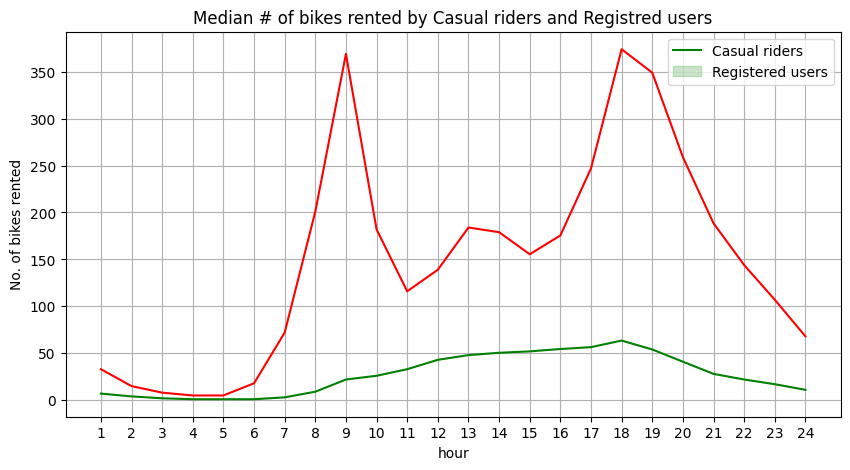

In [227]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=medianUsersPerHour, x="hour", y="casual", color="g", legend="auto")
sns.lineplot(
    data=medianUsersPerHour, x="hour", y="registered", color="r", legend="auto"
)
plt.legend(["Casual riders", "Registered users"])
plt.title("Median # of bikes rented by Casual riders and Registred users")
plt.grid()
plt.xticks(np.arange(1, 25, 1))
plt.ylabel("No. of bikes rented")
plt.show()

## Observations:
- Number of bikes used by Registered users is high.
- Number of bikes used by casual riders is low.
- Registered users bikes frequestly for Office ride/Delievery purposes. 

In [228]:
print("% of casual riders :", round((df["casual"].sum() / df["count"].sum()) * 100, 2))
print(
    "% of registred users:",
    round((df["registered"].sum() / df["count"].sum()) * 100, 2),
)

% of casual riders : 18.8
% of registred users: 81.2


## Using Bootrsapping : Confidence Interval of Mean Number of cycles Rented by Casual And Registered Customers
### Confidence Interval of Mean Number of cycles Rented byRegistered Customers

In [229]:
def confidence_interval_bootstrapping(data, trails=200, sample_size=30000):
    bootstrap_sample = []
    for i in range(trails):
        sample = data.sample(n=sample_size, replace=True)
        sample_mean = sample.mean()
        bootstrap_sample.append(sample_mean)
    standard_error = round(data.std() / np.sqrt(sample_size), 2)
    bootstrap_sample_mean = round(np.mean(bootstrap_sample), 2)
    ci_lower = round(np.percentile(bootstrap_sample, 2.5), 2)
    ci_higher = round(np.percentile(bootstrap_sample, 97.5), 2)

    print(f"Sample mean :{round(bootstrap_sample_mean,2)}")
    print(f"Sample Standard Deviation :{standard_error}")
    print(f"95% Confidence Interval: [{ci_lower},{ci_higher}]")

    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    sns.distplot(data, bins=15)
    plt.subplot(122)
    sns.distplot(bootstrap_sample, bins=15)
    plt.axvline(x=ci_lower, c="r")
    plt.axvline(x=ci_higher, c="r")
    plt.show()

Sample mean :155.44
Sample Standard Deviation :0.87
95% Confidence Interval: [153.83,157.29]


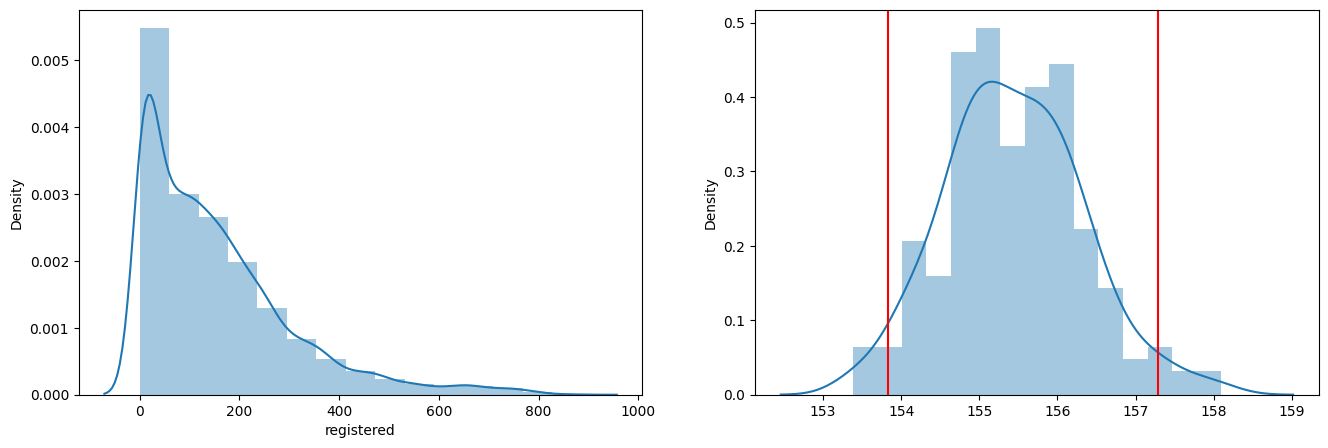

In [230]:
confidence_interval_bootstrapping(df["registered"])

## Confidence Interval of Mean Number of cycles Rented by Casual riders

Sample mean :36.02
Sample Standard Deviation :0.29
95% Confidence Interval: [35.47,36.58]


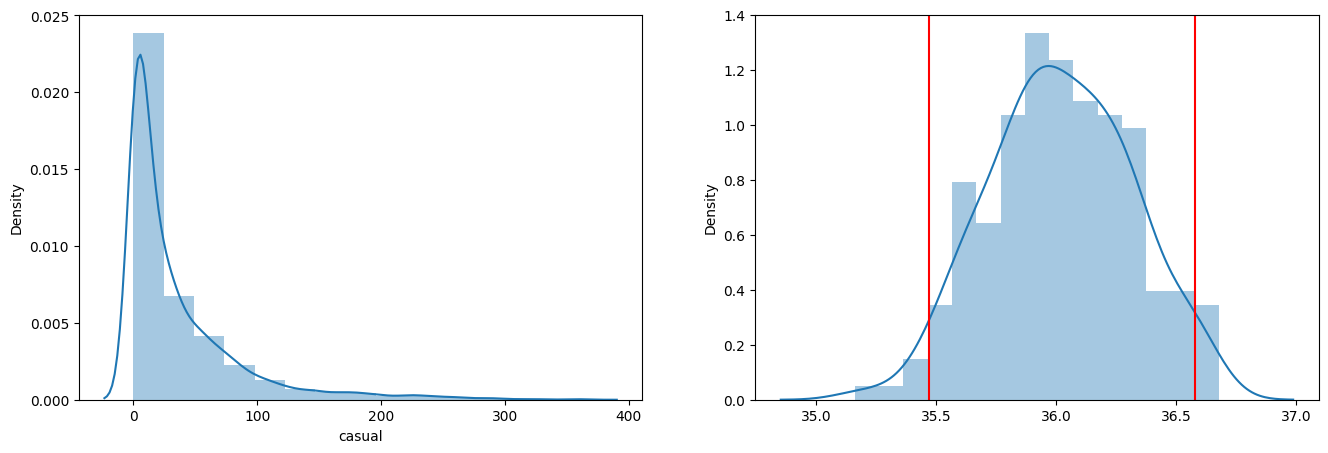

In [231]:
confidence_interval_bootstrapping(df["casual"])

## Hourly median number of cycles rented during the day

In [232]:
# df.groupby('hour')['count'].median()
hourly_bikes_rented = df.groupby("hour")["count"].median()
hourly_bikes_rented = hourly_bikes_rented.reset_index()

In [233]:
hourly_bikes_rented += 1

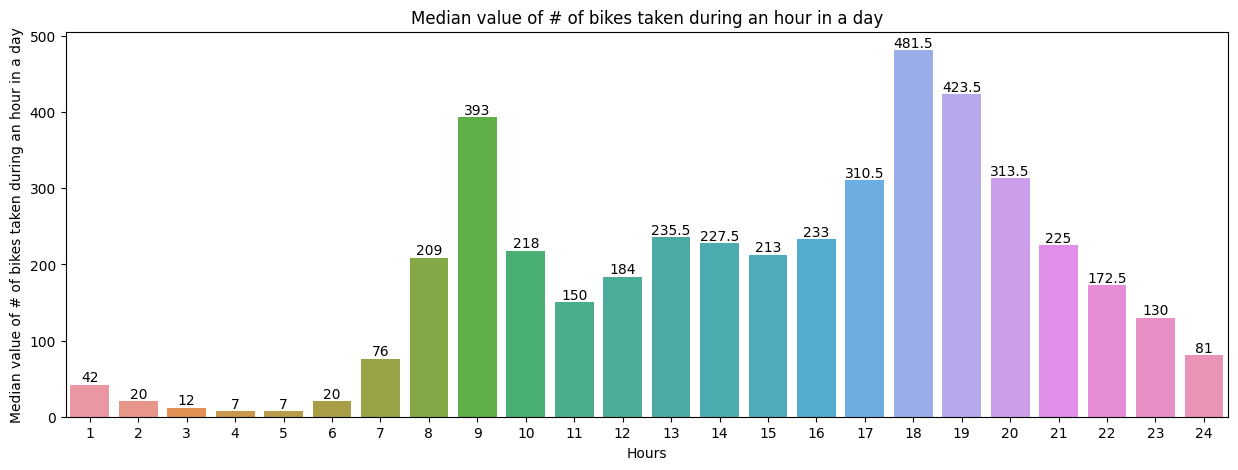

In [234]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=hourly_bikes_rented, x="hour", y="count")
ax.bar_label(ax.containers[0])
plt.ylabel("Median value of # of bikes taken during an hour in a day")
plt.xlabel("Hours")
plt.title("Median value of # of bikes taken during an hour in a day")
print()

## Observation
- Median # of bikes rented are highest between 7:00AM to 9:00AM and 4:00PM to 9:00PM

## Effect of seasons on number of cycles rented during hours

<Axes: xlabel='hour', ylabel='count'>

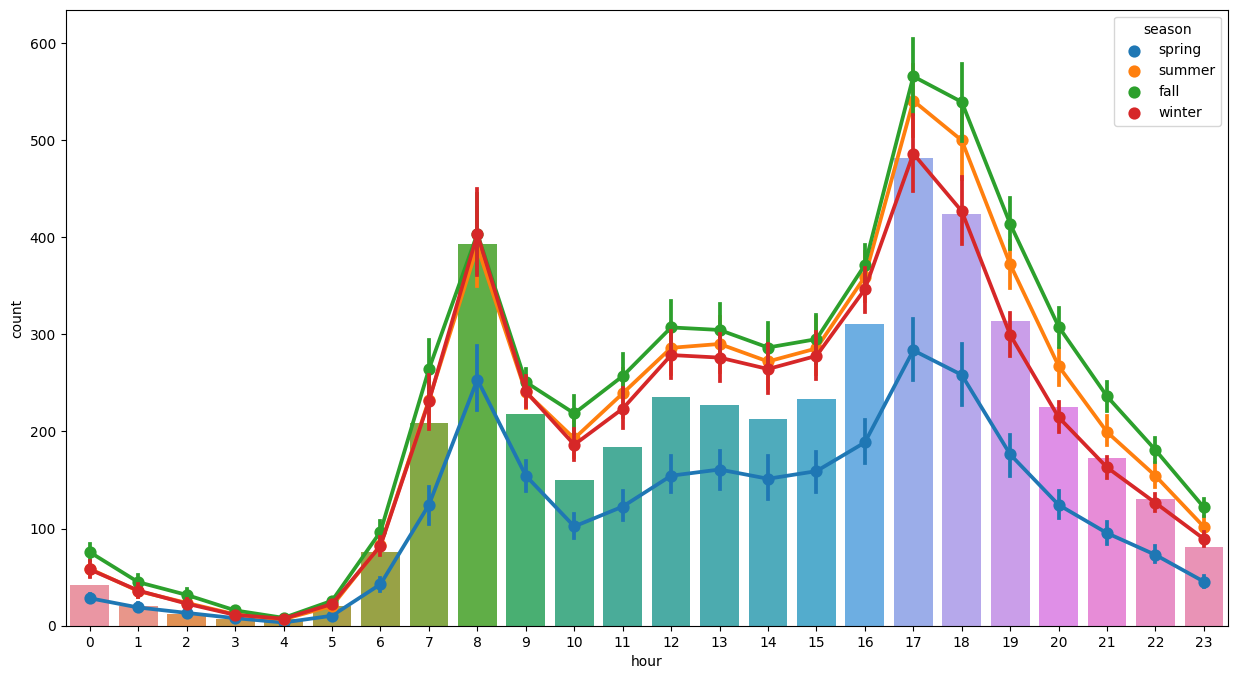

In [235]:
plt.figure(figsize=(15, 8))
sns.barplot(x=hourly_bikes_rented["hour"], y=hourly_bikes_rented["count"])
sns.pointplot(data=df, x="hour", y="count", hue="season")
# hourly_bikes_rented

## Observation:
- During Spring season, people are less likely to book rides.

In [236]:
(df.groupby("season")["count"].sum() / df["count"].sum()) * 100

season
fall      30.720181
spring    14.984493
summer    28.208524
winter    26.086802
Name: count, dtype: float64

## Observation :
- People less likely to book rides during Spring season.

## Weather Effects on cycle rental median counts hourly

In [237]:
df.groupby("weather")["count"].median()

weather
clear          161.0
cloudy         134.0
heavy rain     164.0
little Rain     71.0
Name: count, dtype: float64

In [238]:
weatherBikeRented = (
    round(df.groupby("weather")["count"].sum() / df["count"].sum(), 2) * 100
)
weatherBikeRented = weatherBikeRented.reset_index()
weatherBikeRented = weatherBikeRented.sort_values(by="count", ascending=False)

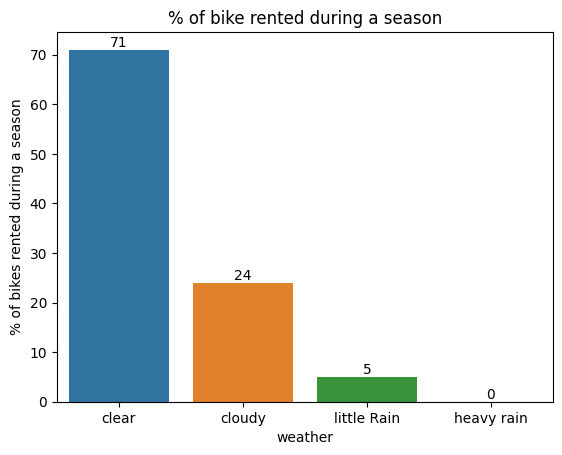

In [239]:
ax = sns.barplot(data=weatherBikeRented, x="weather", y="count")
ax.bar_label(ax.containers[0])
plt.title("% of bike rented during a season")
plt.ylabel("% of bikes rented during a season")
plt.show()

<Axes: xlabel='hour', ylabel='count'>

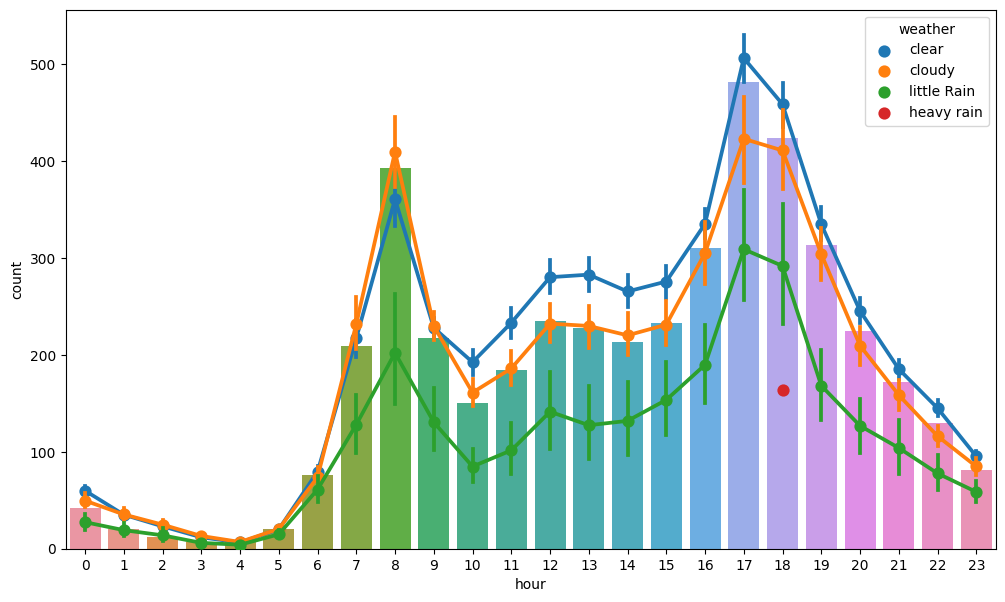

In [240]:
plt.figure(figsize=(12, 7))
sns.barplot(x=hourly_bikes_rented["hour"], y=hourly_bikes_rented["count"])
sns.pointplot(data=df, x="hour", y="count", hue="weather")

## Observation:
- 71% of bike is rented during 'clear' weather.
- 24% of bike is rented during 'cludy' weather.
- Most of the bikes are rented in 'Clear' weather. 

## Offday vs Working day number of cycles rented trend during a day!

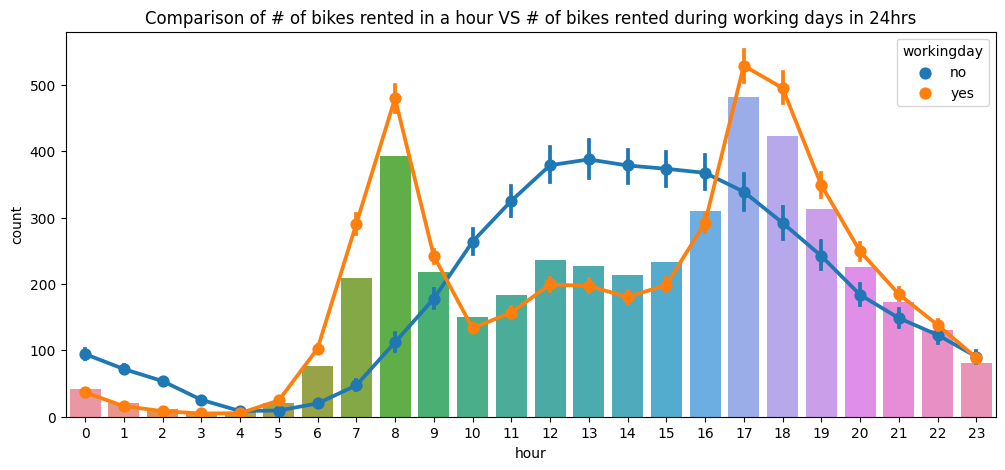

In [241]:
plt.figure(figsize=(12, 5))
sns.barplot(x=hourly_bikes_rented["hour"], y=hourly_bikes_rented["count"])
sns.pointplot(data=df, x="hour", y="count", hue="workingday")
plt.title(
    "Comparison of # of bikes rented in a hour VS # of bikes rented during working days in 24hrs"
)
plt.show()

## observations :
- In working day, more bikes are likely to rented.

<Axes: xlabel='workingday', ylabel='count'>

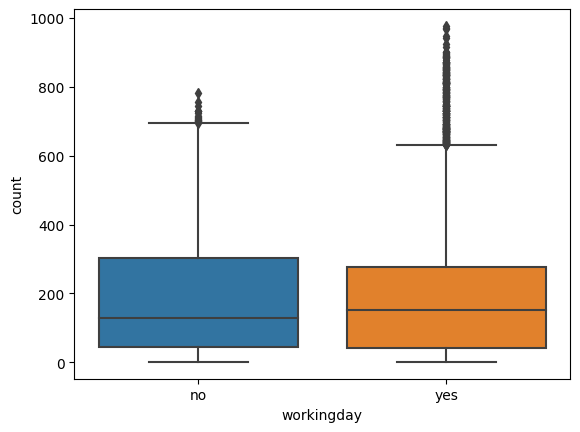

In [242]:
sns.boxplot(data=df, x="workingday", y="count")

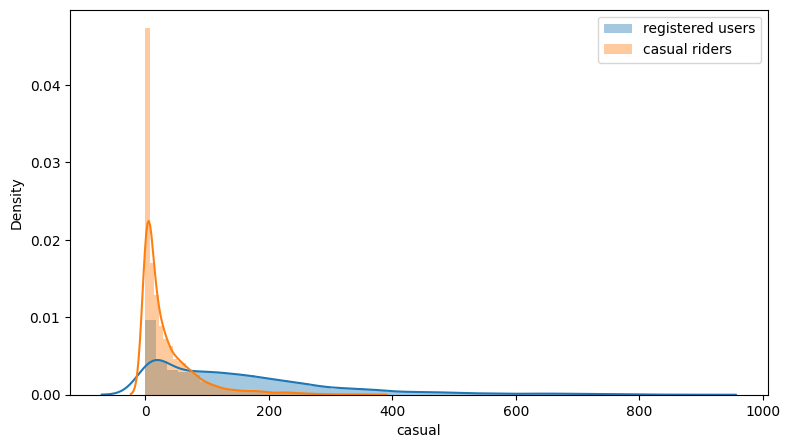

In [243]:
plt.figure(figsize=(9, 5))
sns.distplot(df["registered"], label="registered users")
sns.distplot(df["casual"], label="casual riders")
plt.legend()
plt.show()

## Testing if mean Working Day and off days has effect on number of electric cycles rented.

In [244]:
workingDayYes = df.loc[df["workingday"] == "yes"]["count"]
workingDayNo = df.loc[df["workingday"] == "no"]["count"]

In [245]:
workingDayYes_mean = round(workingDayYes.mean(), 2)
workingDayNo_mean = round(workingDayNo.mean(), 2)
workingDayYes_mean, workingDayNo_mean

(193.01, 188.51)

In [246]:
## HO : mean of # of bikes rented on Working day == mean of # of bikes rented on off day (workingDayYes_mean == workingDayNo_mean)
## HA : mean of # of bikes rented on Working day != mean of # of bikes rented on off day (workingDayYes_mean != workingDayNo_mean)

In [247]:
t_stat, p_value = ttest_ind(workingDayYes, workingDayNo, alternative="two-sided")
t_stat, p_value

(1.2096277376026694, 0.22644804226361348)

In [248]:
alpha = 0.05
print("p_value :", round(p_value, 2))
if p_value < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")

p_value : 0.23
Significance : Fail to reject HO


### Observation : 
- Based on the Hypothesis testing result, we can say that mean of # of bikes rented on working days and off days are significantly same.

## Month and season wise , effect on median and average number of cycles rented .

In [249]:
monthWiseTravel = df.groupby("month")["count"].median()
monthWiseTravel = monthWiseTravel.reset_index()

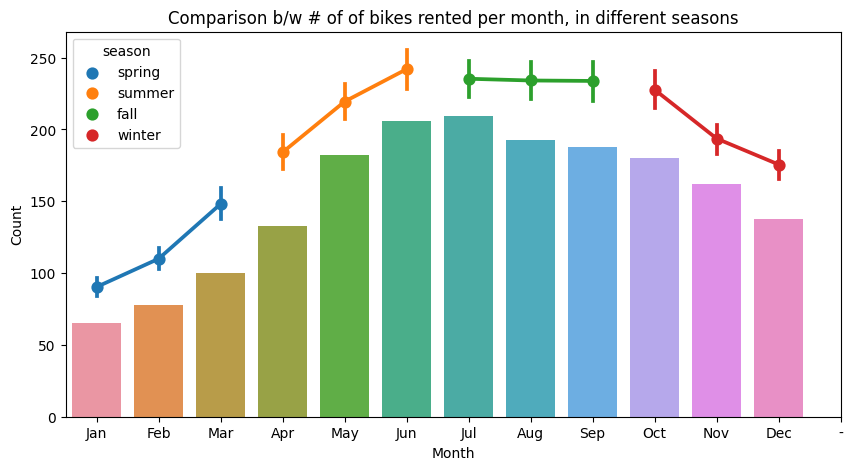

In [250]:
plt.figure(figsize=(10, 5))
sns.barplot(data=monthWiseTravel, x="month", y="count")
sns.pointplot(data=df, x="month", y="count", hue="season")
plt.xticks(
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
        "-",
    ],
)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Comparison b/w # of of bikes rented per month, in different seasons")
plt.show()

## Observations
- In Spring,# of bike rented increases.
- In Winter,# of bike rented decreases.
- In Summer and Winter most of the bikes are rented.
- During Fall, count of monthly rental almost remains same.

## Temprature affect on cycle rented.

In [251]:
(df.groupby("temprature")["count"].sum() / df["count"].sum()) * 100

temprature
high        12.487269
low         30.172248
moderate    53.538617
very low     3.801866
Name: count, dtype: float64

In [252]:
tempCount = df.groupby("hour")["count"].median()
tempCount = tempCount.reset_index()

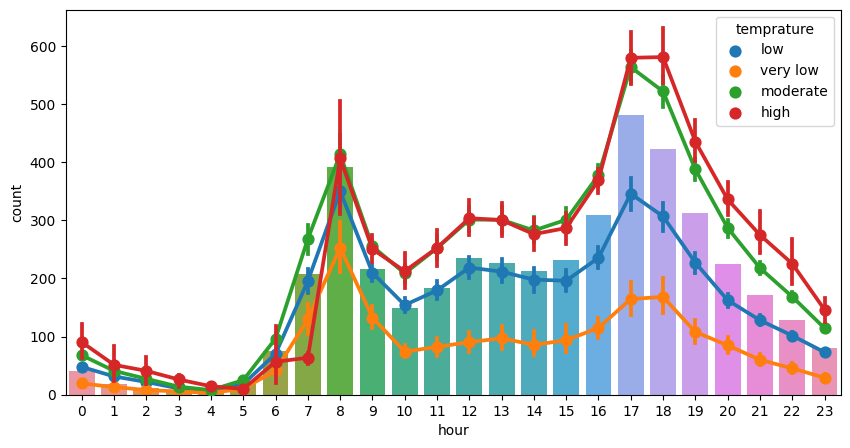

In [253]:
plt.figure(figsize=(10, 5))
sns.barplot(x=tempCount["hour"], y=tempCount["count"])
sns.pointplot(data=df, x="hour", y="count", hue="temprature")
plt.show()

## Observation:
- Average # of bikes rented is high in Moderate and High temprature.

## Weather is dependent on season (check between 2 predictor variable)

In [254]:
df["weather"].dtypes, df["season"].dtypes

(dtype('O'), dtype('O'))

### Both the features 'weather' and 'season' are categorical variables.
- To check whether their is any satistical significance b/w these features ,we will perform Chi-Square test.
- Test of independence is to be performed.
### NULL and Alternate Hypothesis :
- HO : Weather and Season are Independent.
- HA : Weather and Season are Dependent

In [255]:
df["weather"].value_counts()

weather
clear          7192
cloudy         2834
little Rain     859
heavy rain        1
Name: count, dtype: int64

In [256]:
df["season"].value_counts()

season
winter    2734
summer    2733
fall      2733
spring    2686
Name: count, dtype: int64

In [257]:
pd.crosstab(index=df["season"], columns=df["weather"], margins=True)
##since Heavy rain praportion is very less. Removing Heavy rain.

weather,clear,cloudy,heavy rain,little Rain,All
season,,,,,
fall,1930,604,0,199,2733
spring,1759,715,1,211,2686
summer,1801,708,0,224,2733
winter,1702,807,0,225,2734
All,7192,2834,1,859,10886


In [258]:
temp_data = df[df["weather"].isin(["clear", "cloudy", "little Rain"])]

In [259]:
season_weather = pd.crosstab(
    index=temp_data["season"],
    columns=temp_data["weather"],
    values=temp_data["count"],
    aggfunc=np.sum,
    margins=True,
)

In [260]:
chi_stat, p_value, dof, expectation = chi2_contingency(season_weather)
chi_stat, p_value, dof, expectation

(10838.372332480216,
 0.0,
 12,
 array([[ 453484.88557396,  155812.72247031,   31364.39195574,
          640662.        ],
        [ 221081.86259035,   75961.44434981,   15290.69305984,
          312334.        ],
        [ 416408.3330293 ,  143073.60199337,   28800.06497733,
          588282.        ],
        [ 385087.91880639,  132312.23118651,   26633.8500071 ,
          544034.        ],
        [1476063.        ,  507160.        ,  102089.        ,
         2085312.        ]]))

In [263]:
alpha = 0.05
print("p_value :", round(p_value, 2))
if p_value < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")

p_value : 0.0
Significance : Reject HO


### Observations :
- Given Aplha = 0.05 and p_value = 0.0 . We can conclude that we Reject HO.
- Give the data, it's statistically significant that Season and Weather are dependent features.

## Check if weather and Temprature are dependent.

### Both the features 'weather' and 'temprature' are categorical variables.
- To check whether their is any satistical significance b/w these features ,we will perform Chi-Square test.
- Test of independence is to be performed.
### NULL and Alternate Hypothesis :
- HO : Weather and temprature are Independent.
- HA : Weather and temprature are Dependent

In [271]:
weather_temprature_tmp = df[df["weather"].isin(["clear", "cloudy", "little Rain"])]

In [279]:
weather_temprature = pd.crosstab(
    index=weather_temprature_tmp["temprature"],
    columns=weather_temprature_tmp["weather"],
    values=weather_temprature_tmp["count"],
    aggfunc=np.sum,
    margins=True,
)
weather_temprature

weather,clear,cloudy,little Rain,All
temprature,,,,
high,205490,47696,7233,260419
low,409734,186478,33023,629235
moderate,798794,258957,58784,1116535
very low,62045,14029,3049,79123
All,1476063,507160,102089,2085312


In [280]:
chi_stat, p_value, dof, expectation = chi2_contingency(weather_temprature)
chi_stat, p_value, dof, expectation

(22225.586470194507,
 0.0,
 12,
 array([[ 184334.45469887,   63335.41457585,   12749.13072528,
          260419.        ],
        [ 445396.42116144,  153033.6096469 ,   30804.96919166,
          629235.        ],
        [ 790325.86092872,  271547.80224734,   54661.33682394,
         1116535.        ],
        [  56006.26321097,   19243.17352991,    3873.56325912,
           79123.        ],
        [1476063.        ,  507160.        ,  102089.        ,
         2085312.        ]]))

In [281]:
alpha = 0.05
print("p_value :", round(p_value, 2))
if p_value < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")

p_value : 0.0
Significance : Reject HO


### Observations :
- Given Aplha = 0.05 and p_value = 0.0 . We can conclude that we Reject HO.
- Give the data, it's statistically significant that temprature and Weather are dependent features.

## No. of cycles rented similar or in different seasons

In [285]:
df["season"].value_counts()

season
winter    2734
summer    2733
fall      2733
spring    2686
Name: count, dtype: int64

In [286]:
## Here we have 4 samples.

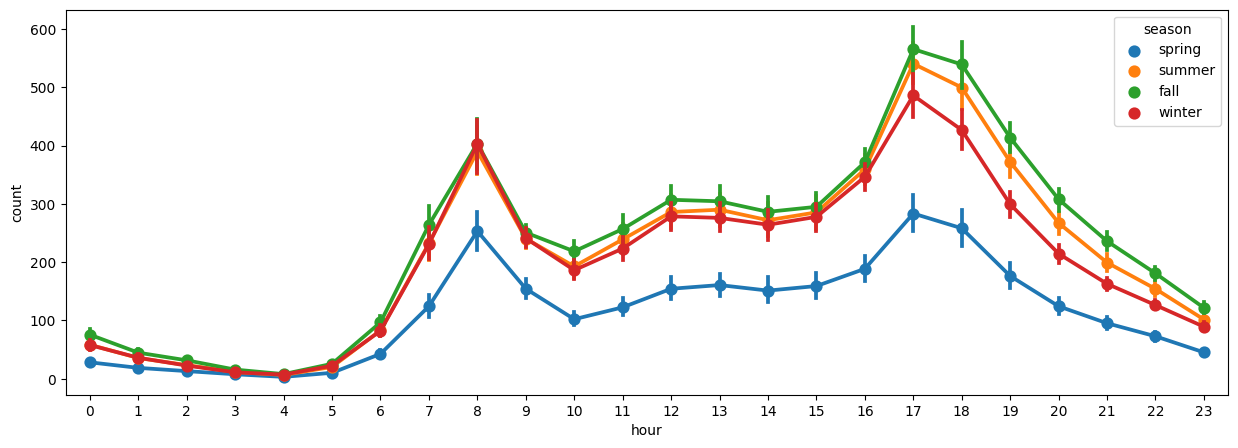

In [292]:
plt.figure(figsize=(15, 5))
sns.pointplot(data=df, x="hour", y="count", hue="season")
plt.show()

### Here we have 4 samples. Therefore we will perform, ANNOVA.
### NULL and Alternate Hypothesis :
- HO : 4 samples have same means.
- HA : 4 sample have different means

In [295]:
spring_sample = df.loc[df["season"] == "spring"]["count"]
summer_sample = df.loc[df["season"] == "summer"]["count"]
fall_sample = df.loc[df["season"] == "fall"]["count"]
winter_sample = df.loc[df["season"] == "winter"]["count"]

### Before going with f_oneway test, firstly we will pre-requisites for Annova:
    1.Gaussian dist.
        - QQ plot
        - Shapiro test
    2.Independence
    3.Equal variance in different groups.
        - Levene test
** Note :  If this conditions doesn't hold than we will perform, Kruskal wallis test

<Axes: xlabel='count', ylabel='Density'>

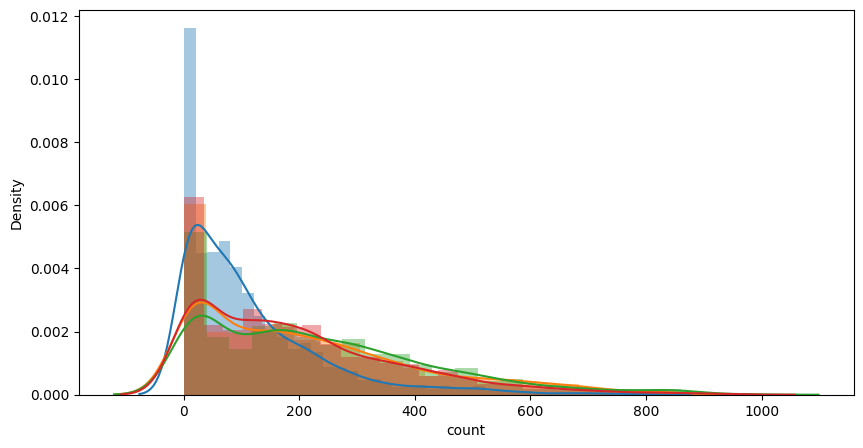

In [310]:
plt.figure(figsize=(10, 5))
sns.distplot(spring_sample, kde=True)
sns.distplot(summer_sample, kde=True)
sns.distplot(fall_sample, kde=True)
sns.distplot(winter_sample, kde=True)

QQ plot for Spring


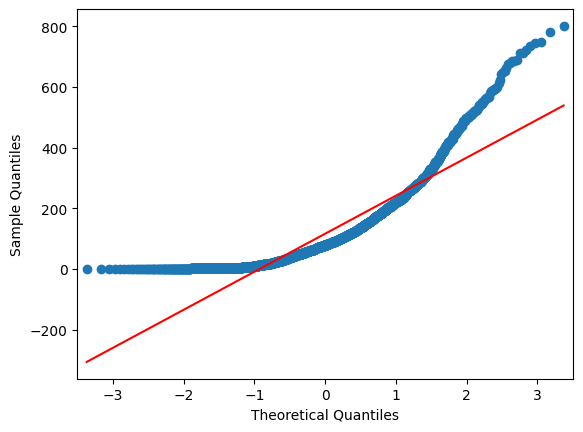

QQ plot for Summer


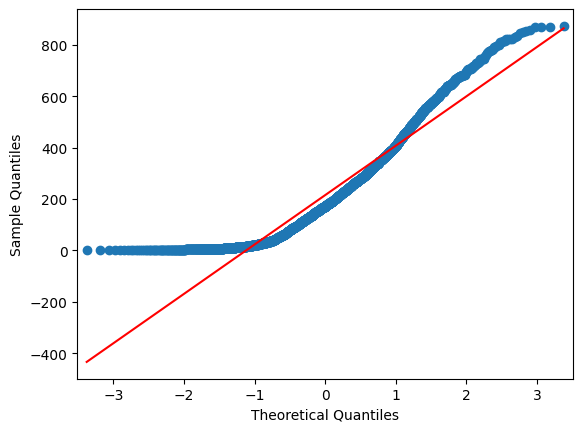

QQ plot for fall


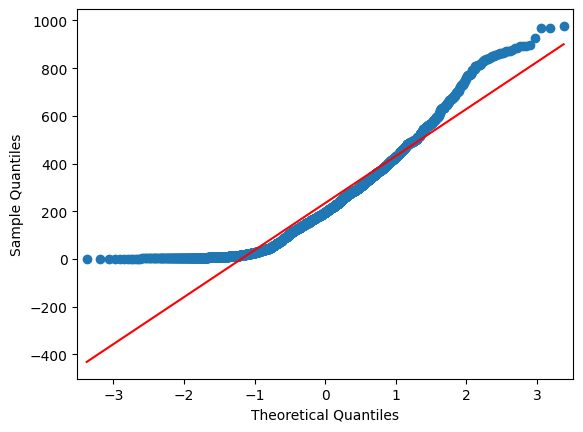

QQ plot for Winter


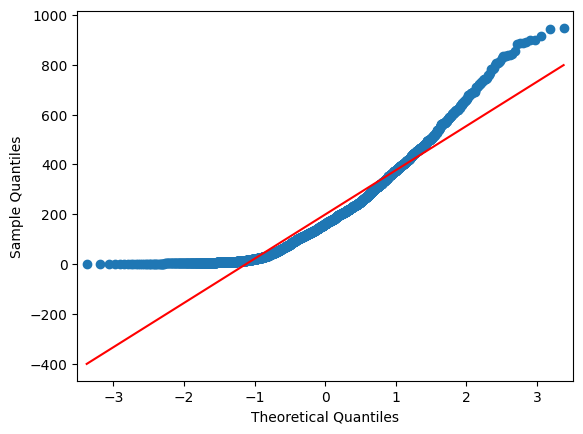

In [315]:
## QQ plot for Spring
print("QQ plot for Spring")
qqplot(spring_sample, line="s")
plt.show()
print("QQ plot for Summer")
qqplot(summer_sample, line="s")
plt.show()
print("QQ plot for fall")
qqplot(fall_sample, line="s")
plt.show()
print("QQ plot for Winter")
qqplot(winter_sample, line="s")
plt.show()

## Shapiro Test
- This test works well smple size is b/w [50,200].
### Null and Alternate Hypothesis
- H0 : Distribution is gaussian
- HA : Distribution is NOT gaussian

In [318]:
s1 = spring_sample.sample(100)
s2 = summer_sample.sample(100)
s3 = fall_sample.sample(100)
s4 = winter_sample.sample(100)

In [320]:
stat_s1, p_value_s1 = shapiro(s1)
stat_s2, p_value_s2 = shapiro(s2)
stat_s3, p_value_s3 = shapiro(s3)
stat_s4, p_value_s4 = shapiro(s4)

In [326]:
alpha = 0.05
print("p_value_s1 :", round(p_value_s1, 2))
if p_value_s1 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)
print("p_value_s2 :", round(p_value_s2, 2))
if p_value_s2 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)

print("p_value_s3 :", round(p_value_s3, 2))
if p_value_s3 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)

print("p_value_s4 :", round(p_value_s4, 2))
if p_value_s4 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)

p_value_s1 : 0.0
Significance : Reject HO
******************************
p_value_s2 : 0.0
Significance : Reject HO
******************************
p_value_s3 : 0.0
Significance : Reject HO
******************************
p_value_s4 : 0.0
Significance : Reject HO
******************************


### Levene Test : Test of variance
- HO : Variances are equal.
- HA : Variance are NOT equal.

In [383]:
stat, p_value = levene(spring_sample, summer_sample, fall_sample, winter_sample)
stat, p_vale

(187.7706624026276, 1.0147116860043298e-118)

In [384]:
print("Levene test result:")
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to Reject HO")
    print("Variances are equal")

Levene test result:
Reject Ho
Variances are not equal


### Observations:
- Since all the assumptions of ANOVA test have failed, now we will perform **Kruskal Wallis test**.

### Null and ALternate Hypothesis for Kruskal Wallis test.

- HO :  Population mean number of cycles rented across different Seasons are same.
- HA :  Population mean number of cycles rented across different Seasons are not same.

In [343]:
k_stat, p_value = kruskal(spring_sample, summer_sample, fall_sample, winter_sample)
k_stat, p_value

(699.6668548181988, 2.479008372608633e-151)

In [344]:
alpha = 0.05
print("p_value :", round(p_value, 2))
if p_value < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")

p_value : 0.0
Significance : Reject HO


## Observation : 
#### -Hence we conclude that the Population mean number of cycles rented across different Seasons are not same.

## If Average No. of cycles rented is similar or different in different weather

In [347]:
df["weather"].value_counts()

weather
clear          7192
cloudy         2834
little Rain     859
heavy rain        1
Name: count, dtype: int64

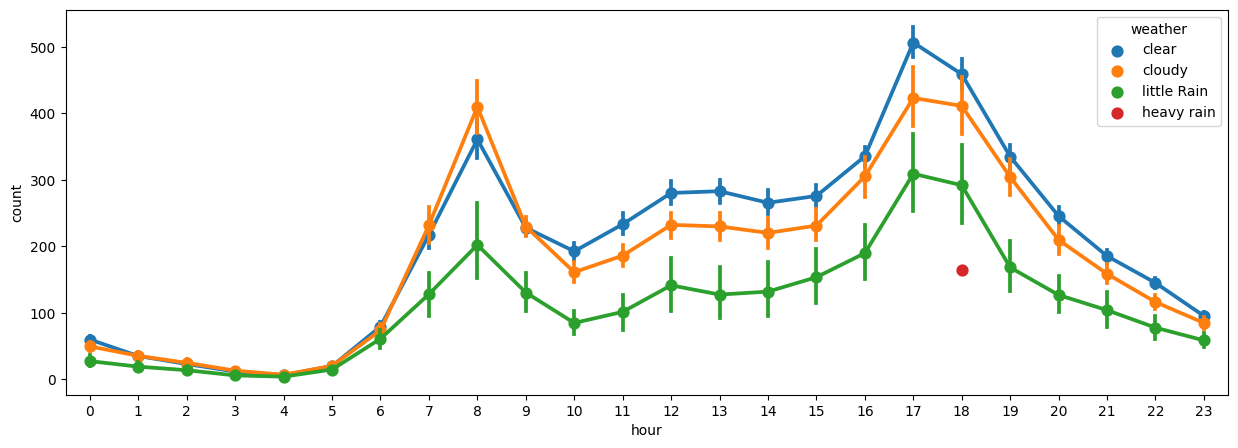

In [351]:
plt.figure(figsize=(15, 5))
sns.pointplot(data=df, x="hour", y="count", hue="weather")
plt.show()

### Here we have 4 samples. Therefore we will perform, ANNOVA.
### NULL and Alternate Hypothesis :
- HO : 4 samples have same means.
- HA : 4 sample have different means

In [366]:
clear_sample = df.loc[df["weather"] == "clear"]["count"]
cloudy_sample = df.loc[df["weather"] == "cloudy"]["count"]
little_rain_sample = df.loc[df["weather"] == "little Rain"]["count"]
heavy_rain_sample = df.loc[df["weather"] == "heavy rain"]["count"]
len(clear_sample), len(cloudy_sample), len(little_rain_sample), len(heavy_rain_sample)

(7192, 2834, 859, 1)

<Axes: xlabel='count', ylabel='Density'>

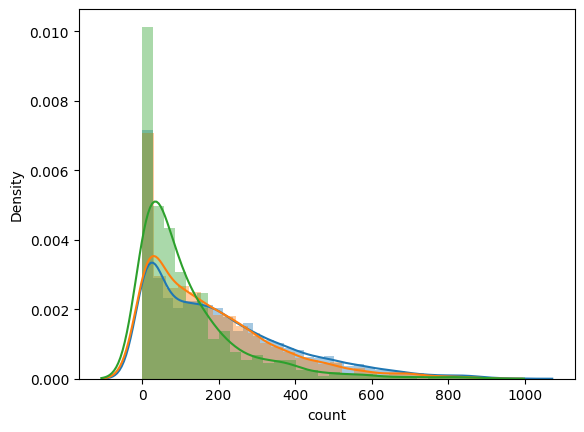

In [375]:
sns.distplot(clear_sample, kde=True)
sns.distplot(cloudy_sample, kde=True)
sns.distplot(little_rain_sample, kde=True)

### Before going with f_oneway test, firstly we will pre-requisites for Annova:
    1.Gaussian dist.
        - QQ plot
        - Shapiro test
    2.Independence
    3.Equal variance in different groups.
        - Levene test
** Note :  If this conditions doesn't hold than we will perform, Kruskal wallis test

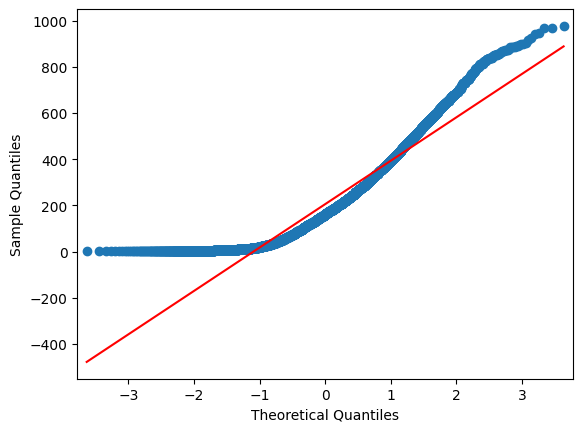

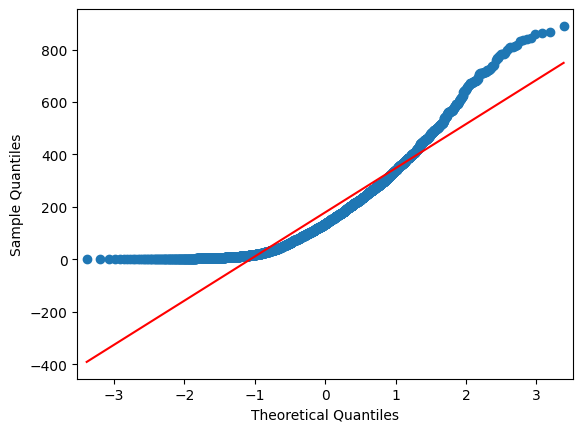

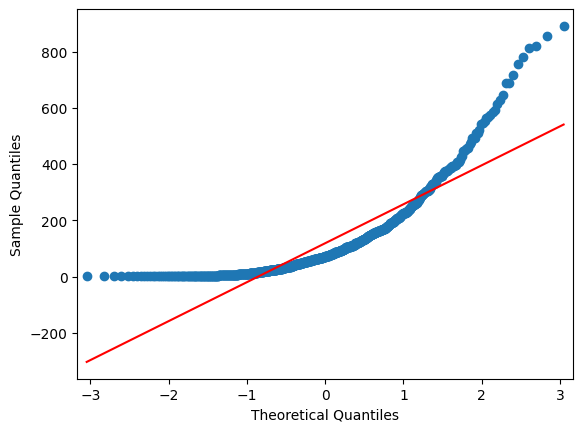

In [377]:
qqplot(clear_sample, line="s")
qqplot(cloudy_sample, line="s")
qqplot(little_rain_sample, line="s")
plt.show()

## Shapiro Test
- This test works well smple size is b/w [50,200].
### Null and Alternate Hypothesis
- H0 : Distribution is gaussian
- HA : Distribution is NOT gaussian

In [392]:
s1 = clear_sample.sample(100)
s2 = cloudy_sample.sample(100)
s3 = little_rain_sample.sample(100)

In [380]:
stat_s1, p_value_s1 = shapiro(s1)
stat_s2, p_value_s2 = shapiro(s2)
stat_s3, p_value_s3 = shapiro(s3)

In [381]:
alpha = 0.05
print("p_value_s1 :", round(p_value_s1, 2))
if p_value_s1 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)
print("p_value_s2 :", round(p_value_s2, 2))
if p_value_s2 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)

print("p_value_s3 :", round(p_value_s3, 2))
if p_value_s3 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)

print("p_value_s4 :", round(p_value_s4, 2))
if p_value_s4 < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")
print("*" * 30)

p_value_s1 : 0.0
Significance : Reject HO
******************************
p_value_s2 : 0.0
Significance : Reject HO
******************************
p_value_s3 : 0.0
Significance : Reject HO
******************************
p_value_s4 : 0.0
Significance : Reject HO
******************************


### Levene Test : Test of variance
- HO : Variances are equal.
- HA : Variance are NOT equal.

In [385]:
stat, p_value = levene(clear_sample, cloudy_sample, little_rain_sample)
stat, p_value

(81.67574924435011, 6.198278710731511e-36)

In [386]:
print("Levene test result:")
if p_value < 0.05:
    print("Reject Ho")
    print("Variances are not equal")
else:
    print("Fail to Reject HO")
    print("Variances are equal")

Levene test result:
Reject Ho
Variances are not equal


### Observations:
- Since all the assumptions of ANOVA test have failed, now we will perform **Kruskal Wallis test**.

### Null and ALternate Hypothesis for Kruskal Wallis test.

- HO :  Population mean number of cycles rented across different Weather are same.
- HA :  Population mean number of cycles rented across different Weather are not same.

In [388]:
k_stat, p_value = kruskal(clear_sample, cloudy_sample, little_rain_sample)
k_stat, p_value

(204.95566833068537, 3.122066178659941e-45)

In [389]:
alpha = 0.05
print("p_value :", round(p_value, 2))
if p_value < alpha:
    print("Significance : Reject HO")
else:
    print("Significance : Fail to reject HO")

p_value : 0.0
Significance : Reject HO


## Observation :
#### -Hence we conclude that the Population mean number of cycles rented across different weather are not same.

# Inferences and Recommendations :
- There is a positive Correlation between Temperature and Number of cycles rented.
- Demand increases with the rise in the temperature from modate to not very high.
- As per shows in the chats in the file , till certain level of humidity level , demand increases , when humidity is too low or very high , there are very few observations.
- Humidity level , 40% to 70% highest records have been observed.
- As per hourly average number of cycles rented by registered and casual customer plots ,
- Registered Customers seems to be using rental cycles mostly for work commute purposes.
- registered customers are much higher than the casual customers. 81% customers are Registered and 19% only are casual riders. Which is good thing for a consistent business. Though it is recommended to introduce
- more go-to offers and strategical execution to attract more casual riders, that further increase chances of converting to consistent users.
- Confidence interval of average number of cycles rented by registered customers is (153,157) and casual customers is (35,37).
- Demand for cycles increases during the rush hours specifically during working days , from morning 7 to 9 am and in evening 4 to 8pm.
- on off days demands are higher from 10 am to evening 7pm.
- Though it is concluded from statistical tests, that demand on weekdays and off-days are similar. We can say demand is equal with 95% confidene.
- During spring season , customers prefer less likely to rent cycle. demand increases in summer and fall season.
- From May to October, demand is increasing .
- During clear and cloudy weather demand is higher than in rainy weather.
- in 2012 , there's 180% hike in demand , from 2011.
- in registered customers , its been 176% hike , where casual customers in 2013 were average 13 to in 2012 are 20.
- **Statistical test results shows:**
    - average number of cycles rented during working days and off days are significantly similar.
    - weather and seasons are dependent.
    - Weather and temperature , Weather and humidity level are also dependent .
    - There's significance difference in demand during different weather and seasons .